In [181]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
from tqdm.notebook import tqdm

In [182]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [183]:
input_size = 100
n_filters = 64
mode_z = 'normal'
image_size = (64, 64)
image_channels = 3
batch_size = 256
num_epochs = 5

# convention for real and fake labels
real_label = 1.
fake_label = 0.

# hyperparameters
beta1 = 0.5
lr_generator = 3e-4
lr_discriminator = 2e-4

current_path = os.path.dirname(os.path.abspath(__name__))
data_path = os.path.normpath(os.path.join(current_path, 'data/celeba/'))

In [184]:
transform = transforms.Compose([
    transforms.Resize(image_size, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(
      mean=(0.5, 0.5, 0.5),
      std=(0.5, 0.5, 0.5)
    )
])
dataset = ImageFolder(root=data_path, transform=transform)
dataset_dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)

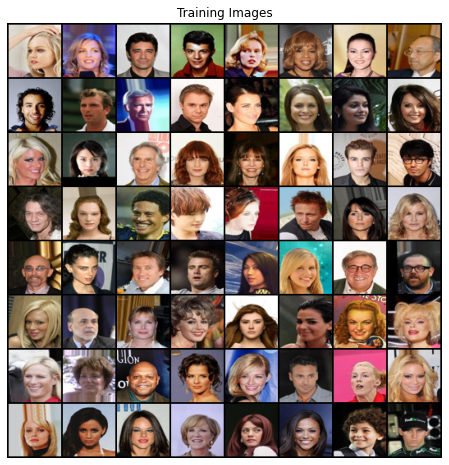

In [185]:
# plot some training images
real_batch = next(iter(dataset_dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),
        (1, 2, 0)
    )
)

In [186]:
def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [187]:
class Generator(nn.Module):
    def __init__(self, input_size, n_filters):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=input_size,
                out_channels=n_filters*8,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.BatchNorm2d(
                num_features=n_filters*8,
                track_running_stats=False
            ),
            nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            ),
            nn.ConvTranspose2d(
                in_channels=n_filters*8,
                out_channels=n_filters*4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(
                num_features=n_filters*4,
                track_running_stats=False
            ),
            nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            ),
            nn.ConvTranspose2d(
                in_channels=n_filters*4,
                out_channels=n_filters*2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(
                num_features=n_filters*2,
                track_running_stats=False
            ),
            nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            ),
            nn.ConvTranspose2d(
                in_channels=n_filters*2,
                out_channels=n_filters,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(
                num_features=n_filters,
                track_running_stats=False
            ),
            nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            ),
            nn.ConvTranspose2d(
                in_channels=n_filters,
                out_channels=image_channels,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.Tanh()          
        )
    def forward(self, input):
        output = self.network(input)
        return output

In [188]:
generator = Generator(
    input_size=input_size,
    n_filters=n_filters
).to(device=device)

generator.apply(weight_init)
print(generator.network)

Sequential(
  (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2

In [189]:
class Discriminator(nn.Module):
    def __init__(self, n_filters):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(
                in_channels=image_channels,
                out_channels=n_filters,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            ),
            nn.Conv2d(
                in_channels=n_filters,
                out_channels=n_filters*2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(
                num_features=n_filters*2,
                track_running_stats=False
            ),
            nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            ),
            nn.Conv2d(
                in_channels=n_filters*2,
                out_channels=n_filters*4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(
                num_features=n_filters*4,
                track_running_stats=False
            ),
            nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            ),
            nn.Conv2d(
                in_channels=n_filters*4,
                out_channels=n_filters*8,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(
                num_features=n_filters*8,
                track_running_stats=False
            ),
            nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            ),
            nn.Conv2d(
                in_channels=n_filters*8,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.Sigmoid()          
        )
    def forward(self, input):
        output = self.network(input)
        return output

In [190]:
discriminator = Discriminator(
    n_filters=n_filters
).to(device=device)

discriminator.apply(weight_init)
print(discriminator.network)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (12): Sigmoid()
)


In [191]:
loss_func = nn.BCELoss()
generator_optimizer = torch.optim.Adam(
    params=generator.parameters(), 
    lr=lr_generator,
    betas=(beta1, 0.999)
)
discriminator_optimizer = torch.optim.Adam(
    params=discriminator.parameters(),
    lr=lr_discriminator,
    betas=(beta1, 0.999)
)

In [192]:
def create_noise(batch_size, input_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, input_size, 1, 1, device=device) * 2 - 1
    elif mode_z == 'normal':
        input_z = torch.rand(batch_size, input_size, 1, 1, device=device)
    return input_z

# convention for real and fake labels
real_label = 1.
fake_label = 0.

def train_discriminator(input: torch.Tensor):
    discriminator.zero_grad()
    batch_size = input.size(0)
    input = input.to(device)
    discriminator_labels_real = torch.full((batch_size,), real_label, dtype=torch.float, device=device) 
    discriminator_prob_real = discriminator(input).squeeze() 
    discriminator_loss_real = loss_func(discriminator_prob_real, discriminator_labels_real)
    input_z = create_noise(batch_size, input_size, mode_z)
    generator_output = generator(input_z)
    discriminator_prob_fake = discriminator(generator_output).squeeze()
    discriminator_labels_fake = torch.full((batch_size,), fake_label, dtype=torch.float, device=device) 
    discriminator_loss_fake = loss_func(discriminator_prob_fake, discriminator_labels_fake)
    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    discriminator_loss.backward()
    discriminator_optimizer.step()
    return (
        discriminator_loss.data.item(),
        discriminator_prob_real.detach(),
        discriminator_prob_fake.detach()
    )

def train_generator(input: torch.Tensor):
    generator.zero_grad()
    batch_size = input.size(0)
    input_z = create_noise(batch_size, input_size, mode_z).to(device)
    generator_labels_real = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
    generator_output = generator(input_z).squeeze()
    discriminator_prob_fake = discriminator(generator_output).squeeze()
    generator_loss = loss_func(discriminator_prob_fake, generator_labels_real)
    generator_loss.backward()
    generator_optimizer.step()
    return generator_loss.data.item()

In [193]:
def create_samples(generator, input_z):
    generator_output = generator(input_z)
    images = torch.reshape(generator_output, (batch_size, *image_size, image_channels))
    return (images + 1) / 2.0


fixed_z = create_noise(batch_size, input_size, mode_z).to(device)
torch.manual_seed(1)

discriminator_losses = []
generator_losses = []
epoch_samples = []

for epoch in range(1, num_epochs+1):
    generator.train()
    for i, (input, *_) in tqdm(enumerate(dataset_dataloader)):
        discriminator_loss, discriminator_prob_real, discriminator_prob_fake = train_discriminator(input)
        discriminator_losses.append(discriminator_loss)
        generator_loss = train_generator(input)
        generator_losses.append(generator_loss)
    print(  f'Epoch {epoch:03d} | Avg Losses >>'
            f' G/D {torch.FloatTensor(generator_losses).mean():.4f}'
            f'/{torch.FloatTensor(discriminator_losses).mean():.4f}')
    generator.eval()
    epoch_samples.append(
        create_samples(
            generator, fixed_z
        ).detach().cpu().numpy()
    )

    # save weights
    model_path = f"./celeb_wgan_dis_{epoch}.pt"
    torch.save(discriminator, model_path)

    model_path = f"./celeb_wgan_gen_{epoch}.pt"
    torch.save(generator, model_path)

0it [00:00, ?it/s]

Epoch 001 | Avg Losses >> G/D 7.6100/0.7094


0it [00:00, ?it/s]

Epoch 002 | Avg Losses >> G/D 6.3195/0.6794


0it [00:00, ?it/s]

Epoch 003 | Avg Losses >> G/D 6.1443/0.6339


0it [00:00, ?it/s]

Epoch 004 | Avg Losses >> G/D 6.0442/0.5820


0it [00:00, ?it/s]

Epoch 005 | Avg Losses >> G/D 6.0656/0.5379


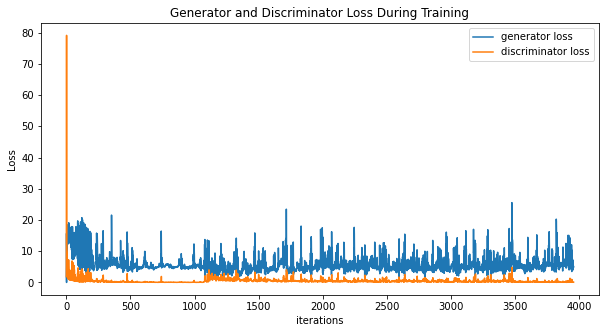

In [194]:
# plot results
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_losses, label="generator loss")
plt.plot(discriminator_losses, label="discriminator loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

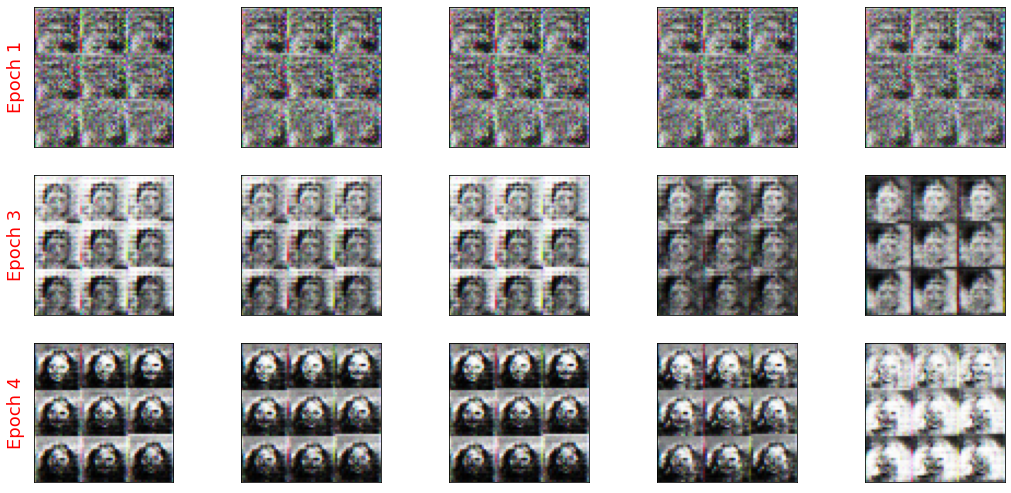

In [198]:
# plot results
selected_epochs = [1, 3, 4, 5, 10, 15, 20, 25, 50, 100]
max_epoch = len(epoch_samples) - 1
fig = plt.figure(figsize=(18, 18))
for i, epoch in enumerate(selected_epochs):
    if epoch > max_epoch:
        break
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {epoch}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes
            )
        image = epoch_samples[epoch - 1][j]
        ax.imshow(image, cmap='gray_r')
plt.show()